Step 1: Load & initial audit

In [ ]:
import pandas as pd
import numpy as np

# Step 1: Load & initial audit
file_path = "Airbnb_Open_Data.csv"

df = pd.read_csv(file_path)

df.head()

In [ ]:
attr_summary_step1 = pd.DataFrame({
    "dtype": df.dtypes.astype(str),
    "null_count": df.isna().sum(),
})

attr_summary_step1

Step 2: Duplicate Checking

In [ ]:
# Step 2: Duplicate checking for listing id
id_dup_count = df["id"].duplicated().sum()
print(f"Duplicate id count: {id_dup_count}")

# Show sample duplicate ids if any
if id_dup_count > 0:
    dup_ids = df.loc[df["id"].duplicated(), "id"].head(10)
    print("Sample duplicate ids:", dup_ids.tolist())
else:
    print("No duplicate ids found.")


In [ ]:
# Remove duplicate rows by listing id
before_rows = len(df)
df = df.drop_duplicates(subset=["id"]).reset_index(drop=True)
removed = before_rows - len(df)
print(f"Removed {removed} duplicate rows. Remaining rows: {len(df)}")


Step 3: Missing value checking

In [ ]:
# Step 3: Missing value report
missing_summary = pd.DataFrame({
    "missing_count": df.isna().sum(),
})

missing_summary

Step 4: Remove Outliner

In [ ]:
# Clean 'minimum nights': set negative or >90 to NaN
min_nights_col = "minimum nights"
if min_nights_col in df.columns:
    df[min_nights_col] = pd.to_numeric(df[min_nights_col], errors="coerce")
    invalid_mask = (df[min_nights_col] < 0) | (df[min_nights_col] > 90)
    df.loc[invalid_mask, min_nights_col] = np.nan
    print(f"Set {invalid_mask.sum()} invalid '{min_nights_col}' values to NaN")
else:
    print(f"Column '{min_nights_col}' not found")


In [ ]:
# Clean 'availability 365': set negative or >365 to NaN
avail_col = "availability 365"
if avail_col in df.columns:
    df[avail_col] = pd.to_numeric(df[avail_col], errors="coerce")
    invalid_mask = (df[avail_col] < 0) | (df[avail_col] > 365)
    df.loc[invalid_mask, avail_col] = np.nan
    print(f"Set {invalid_mask.sum()} invalid '{avail_col}' values to NaN")
else:
    print(f"Column '{avail_col}' not found")

Step 5: Preparation for Filling Missing Value

In [ ]:
# Reformat price and service fee to plain numeric
money_cols = ["price", "service fee"]
for col in money_cols:
    if col in df.columns:
        df[col] = (
            df[col]
            .astype(str)
            .str.replace("$", "", regex=False)
            .str.replace(",", "", regex=False)
        )
        df[col] = pd.to_numeric(df[col], errors="coerce")
        print(f"Reformatted '{col}' to numeric")
    else:
        print(f"Column '{col}' not found")

In [ ]:
# Fix typos and standardize 'neighbourhood group'
if ng_col in df.columns:
    ng_series = df[ng_col].astype("string")
    ng_clean_base = ng_series.str.strip()
    ng_lower = ng_clean_base.str.lower()

    ng_map = {
        "manhatan": "Manhattan",
        "manhatten": "Manhattan",
        "manhattan": "Manhattan",
        "brooklyn": "Brooklyn",
        "brookln": "Brooklyn",
        "queens": "Queens",
        "bronx": "Bronx",
        "staten island": "Staten Island",
        "statenisland": "Staten Island",
    }

    ng_fixed = ng_lower.map(ng_map).fillna(ng_clean_base.str.title())
    changed_mask = ng_series.notna() & (ng_lower != ng_fixed.str.lower())

    if changed_mask.any():
        print(f"Fixed {int(changed_mask.sum())} '{ng_col}' values")
        print("Before -> After (counts):")
        change_summary = (
            pd.DataFrame({
                "before": ng_series[changed_mask].fillna("<NA>"),
                "after": ng_fixed[changed_mask].fillna("<NA>"),
            })
            .value_counts()
            .reset_index(name="count")
        )
        change_summary
    else:
        print(f"No typos detected in '{ng_col}'")

    df[ng_col] = ng_fixed
else:
    print(f"Column '{ng_col}' not found")

Step 6: Filling Missing Value

In [ ]:
# Fill missing values
string_cols = [
    "host_identity_verified",
    "neighbourhood group",
    "country",
    "instant_bookable",
    "cancellation_policy",
]
float_max_cols = ["Construction year", "review rate number"]
float_mean_cols = [
    "price",
    "service fee",
    "number of reviews",
    "minimum nights",
    "reviews per month",
    "calculated host listings count",
    "availability 365",
]

for col in string_cols:
    if col in df.columns:
        fill_value = df[col].dropna().max()
        df[col] = df[col].fillna(fill_value)
        print(f"Filled missing '{col}' with max value: {fill_value}")
    else:
        print(f"Column '{col}' not found")

for col in float_max_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        fill_value = df[col].max()
        df[col] = df[col].fillna(fill_value)
        print(f"Filled missing '{col}' with max value: {fill_value}")
    else:
        print(f"Column '{col}' not found")

for col in float_mean_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors="coerce")
        fill_value = df[col].mean()
        df[col] = df[col].fillna(fill_value)
        print(f"Filled missing '{col}' with mean value: {fill_value}")
    else:
        print(f"Column '{col}' not found")


In [ ]:
# Recheck missing values after cleaning
missing_summary_after = pd.DataFrame({
    "missing_count": df.isna().sum(),
})

missing_summary_after


Step 7: Remove Unused Column

In [ ]:
# Drop unused columns and save cleaned dataframe
cols_to_drop = [
    "NAME",
    "host name",
    "neighbourhood",
    "lat",
    "long",
    "country code",
    "last review",
    "house_rules",
    "license",
]

cleaned_data = df.drop(columns=cols_to_drop, errors="ignore")
print(f"cleaned_data shape: {cleaned_data.shape}")


In [ ]:
# List attributes with data type and null count
attr_summary = pd.DataFrame({
    "dtype": cleaned_data.dtypes.astype(str),
    "null_count": cleaned_data.isna().sum(),
}).sort_index()

attr_summary

# Overwrite original CSV with cleaned data
output_path = "Airbnb_Open_Data_cleaned.csv"
cleaned_data.to_csv(output_path, index=False)
print(f"Saved cleaned_data to {output_path}")


Step 8: Visualisation

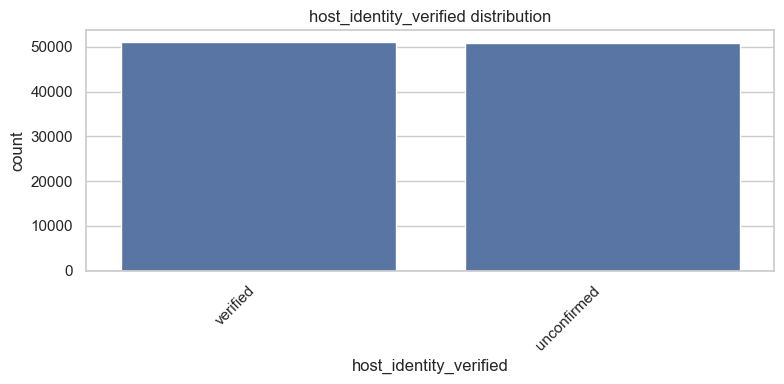

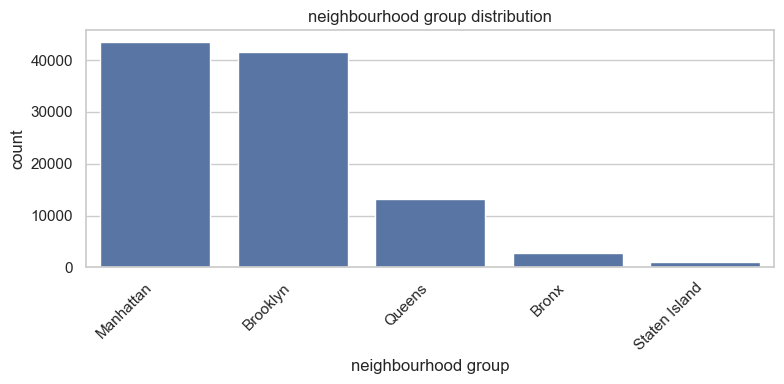

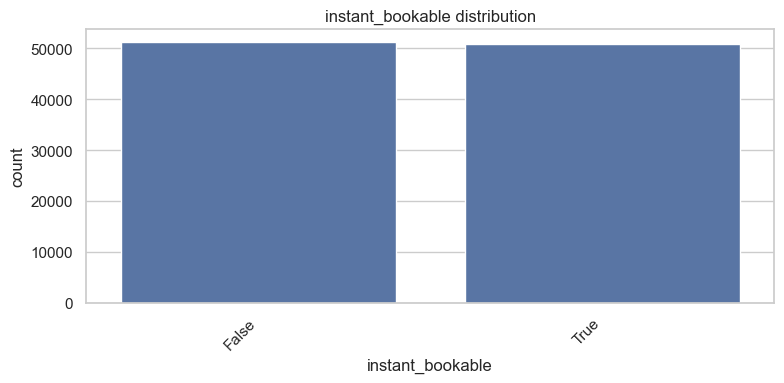

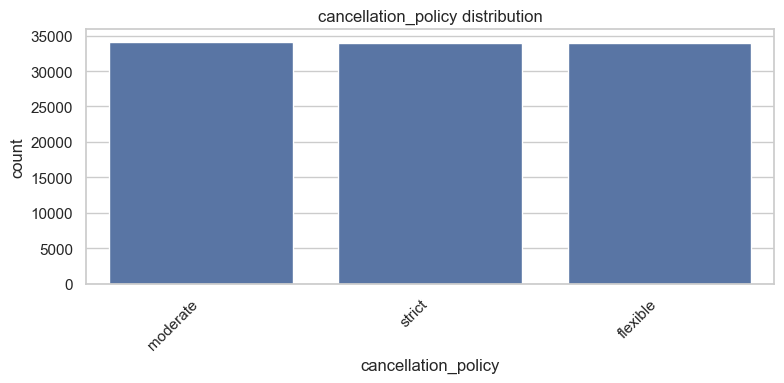

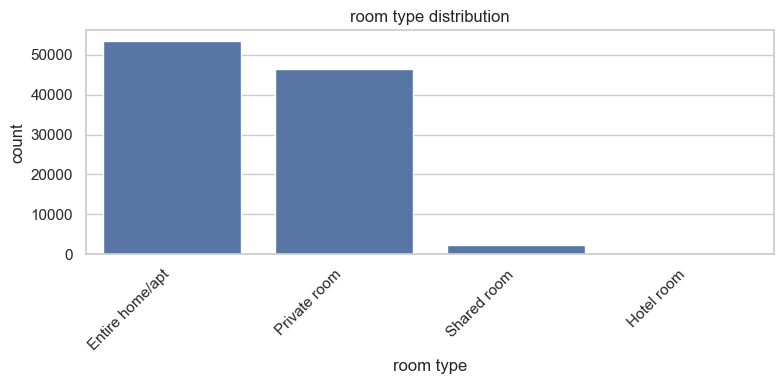

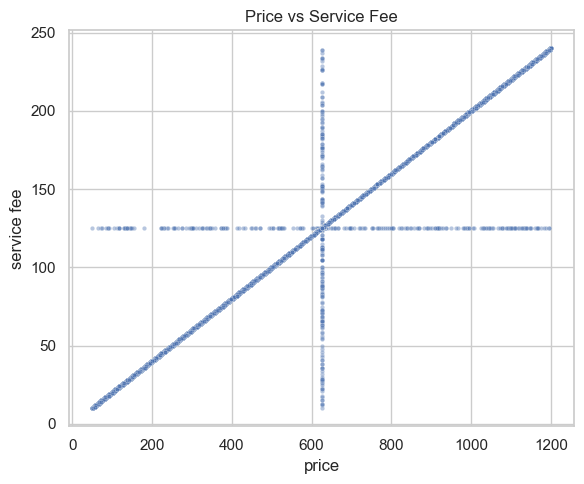

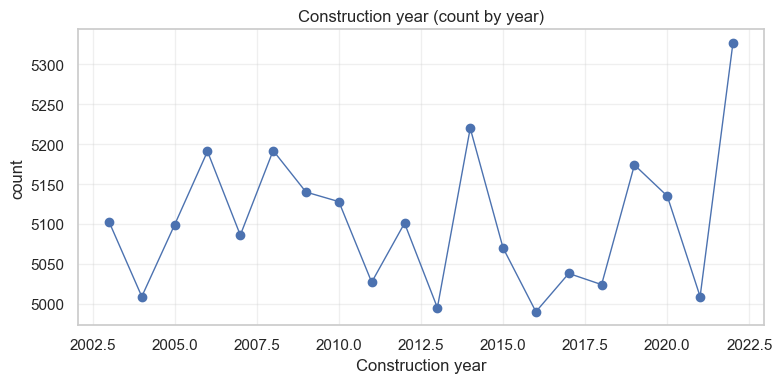

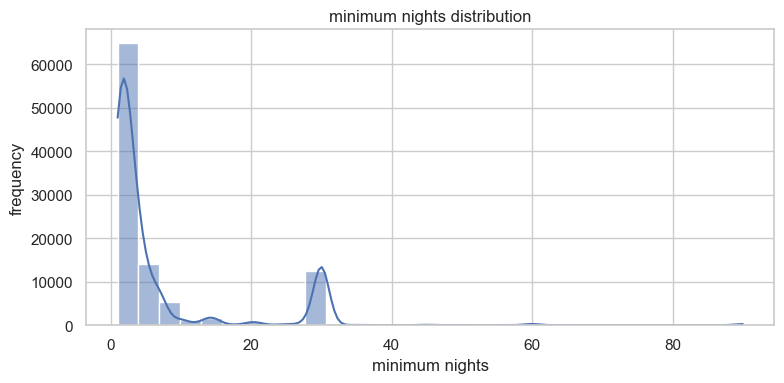

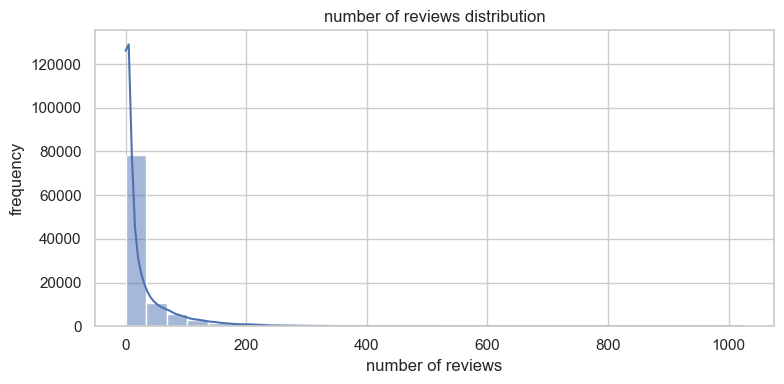

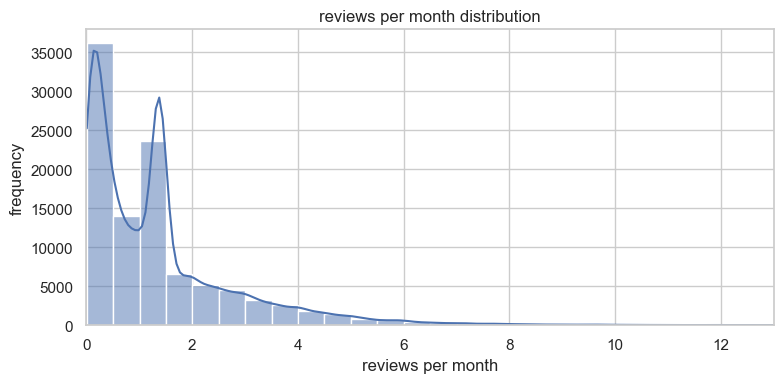

<Figure size 800x400 with 0 Axes>

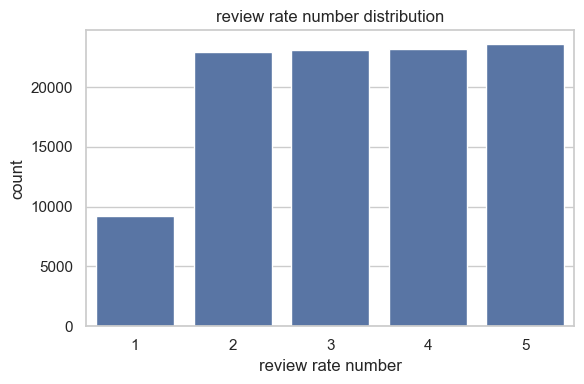

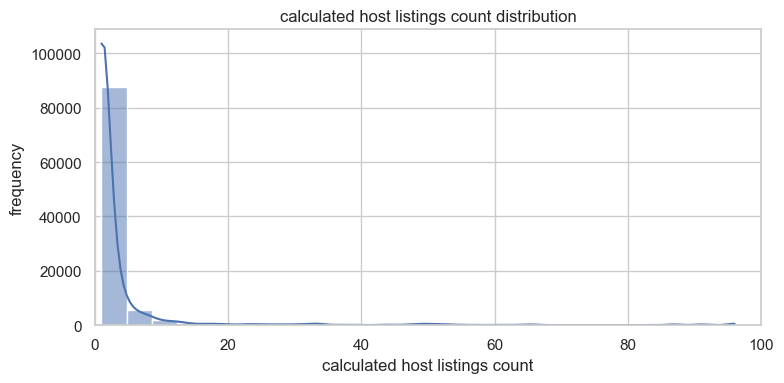

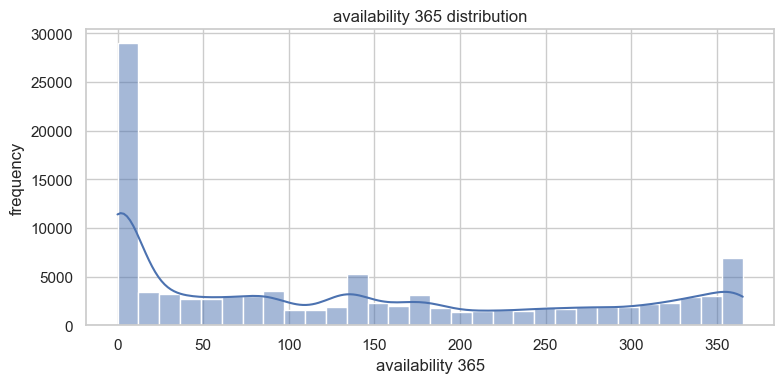

In [303]:
# Step 8: Visualizations for key attributes
import matplotlib.pyplot as plt

try:
    import seaborn as sns
    sns.set_theme(style="whitegrid")
except ImportError:
    sns = None

viz_df = cleaned_data if "cleaned_data" in globals() else df

categorical_cols = [
    "host_identity_verified",
    "neighbourhood group",
    "instant_bookable",
    "cancellation_policy",
    "room type",
]

numeric_cols = [
    "minimum nights",
    "number of reviews",
    "reviews per month",
    "review rate number",
    "calculated host listings count",
    "availability 365",
]

# Categorical plots
for col in categorical_cols:
    if col not in viz_df.columns:
        print(f"Column '{col}' not found, skipping.")
        continue

    plt.figure(figsize=(8, 4))
    counts = viz_df[col].astype("string").value_counts(dropna=False)
    if sns is not None:
        sns.barplot(x=counts.index.astype(str), y=counts.values)
    else:
        counts.plot(kind="bar")
    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("count")
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

# Price vs service fee (combined view)
price_col = "price"
fee_col = "service fee"
if price_col in viz_df.columns and fee_col in viz_df.columns:
    price_series = pd.to_numeric(viz_df[price_col], errors="coerce")
    fee_series = pd.to_numeric(viz_df[fee_col], errors="coerce")
    valid_mask = price_series.notna() & fee_series.notna()

    plt.figure(figsize=(6, 5))
    if sns is not None:
        sns.scatterplot(x=price_series[valid_mask], y=fee_series[valid_mask], s=10, alpha=0.4)
    else:
        plt.scatter(price_series[valid_mask], fee_series[valid_mask], s=10, alpha=0.4)
    plt.title("Price vs Service Fee")
    plt.xlabel("price")
    plt.ylabel("service fee")
    plt.tight_layout()
    plt.show()
else:
    print("Price/service fee columns not found, skipping combined plot.")

# Construction year
line_df = cleaned_data if "cleaned_data" in globals() else df
col = "Construction year"

if col not in line_df.columns:
    print(f"Column '{col}' not found, skipping.")
else:
    series = pd.to_numeric(line_df[col], errors="coerce").dropna()
    counts = series.value_counts().sort_index()

    plt.figure(figsize=(8, 4))
    plt.plot(counts.index, counts.values, marker="o", linewidth=1)
    plt.title("Construction year (count by year)")
    plt.xlabel("Construction year")
    plt.ylabel("count")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Numeric plots
for col in numeric_cols:
    if col not in viz_df.columns:
        print(f"Column '{col}' not found, skipping.")
        continue

    plt.figure(figsize=(8, 4))
    series = pd.to_numeric(viz_df[col], errors="coerce")

    if col == "reviews per month":
        series = series[(series >= 0) & (series <= 13)]
        bins = 26
    elif col == "calculated host listings count":
        series = series[(series >= 0) & (series <= 100)]
        bins = 25
    elif col == "review rate number":
        series = series[(series >= 1) & (series <= 5)]
        bins = range(1, 7)
    else:
        bins = 30

    if col == "review rate number":
        counts = series.dropna().round(0).astype(int).value_counts().sort_index()
        plt.figure(figsize=(6, 4))
        if sns is not None:
            sns.barplot(x=counts.index.astype(str), y=counts.values)
        else:
            counts.plot(kind="bar")
        plt.xticks(rotation=0)
        plt.title(f"{col} distribution")
        plt.xlabel(col)
        plt.ylabel("count")
        plt.tight_layout()
        plt.show()
        continue

    if sns is not None:
        sns.histplot(series.dropna(), bins=bins, kde=True)
    else:
        series.dropna().plot(kind="hist", bins=bins)

    if col == "reviews per month":
        plt.xlim(0, 13)
    if col == "calculated host listings count":
        plt.xlim(0, 100)

    plt.title(f"{col} distribution")
    plt.xlabel(col)
    plt.ylabel("frequency")
    plt.tight_layout()
    plt.show()
